In [1]:
import mir_eval
from __future__ import division

import os

import librosa
import medleydb as mdb

import numpy as np
import scipy

import matplotlib.pyplot as plt
import IPython.display

import seaborn as sns
%matplotlib inline

import pandas as pd

import jams
import itertools

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [2]:
def getOnsetTimes(j):
    
    return j.search(namespace='onset')[0].data.to_interval_values()[0][:, 0]

def findIdxFalsePos(est_idxTruePos, onset_est):

    numEstPos = len(onset_est)

    est_idxFalsePos = list(set(range(numEstPos)) - set(est_idxTruePos))
    est_idxFalsePos.sort()
    
    return est_idxFalsePos

def findMissing(idxTruePos, idxOnset):

    numEstPos = len(idxOnset)

    idxMissing = list(set(range(numEstPos)) - set(idxTruePos))
    idxMissing.sort()
    
    return idxMissing

In [3]:
refBaseDir = './OnsetAnnotation_truth/'
estBaseDir = './OnsetEstimation_spectralFlux/'

annotations = os.listdir(refBaseDir)

OSError: [Errno 2] No such file or directory: './OnsetAnnotation_truth/'

In [9]:
a = annotations[0]

refPath = os.path.join(refBaseDir,a)
estPath = os.path.join(estBaseDir,a)

j_ref = jams.load(refPath)
j_est = jams.load(estPath)

onset_ref = getOnsetTimes(j_ref)
onset_est = getOnsetTimes(j_est)

In [11]:
keyList  = ['relStemPowerBin', 'onsetSource', 'polyphony']
summary = [pd.DataFrame(),pd.DataFrame(),pd.DataFrame()]

for a in annotations:

    refPath = os.path.join(refBaseDir,a)
    estPath = os.path.join(estBaseDir,a)

    j_ref = jams.load(refPath)
    j_est = jams.load(estPath)

    onset_ref = getOnsetTimes(j_ref)
    onset_est = getOnsetTimes(j_est)

    match = mir_eval.util.match_events(onset_ref,onset_est,0.05)

    est_idxTruePos = [m[1] for m in match]
    est_idxFalsePos = findMissing(est_idxTruePos, onset_est)

    ref_idxTruePos = [m[0] for m in match]
    ref_idxFalseNeg = findMissing(ref_idxTruePos, onset_ref)

    df = pd.DataFrame(j_ref.search(namespace='onset')[0].data.value.tolist())
    df.onsetSource = df.onsetSource.map(lambda x: "/".join(x))
    df['relStemPower'] = df.powerStem - df.powerMix 
    df['relStemPower'] = df.powerStem - df.powerMix 
    df['relStemPowerBin'] = pd.cut(df.relStemPower,bins = np.linspace(-70,2,25))
    df['TP'] = 0
    df['FN'] = 0

    df['TP'].loc[ref_idxTruePos] = 1
    df['FN'].loc[ref_idxFalseNeg] = 1
    
    for i, key in enumerate(keyList):

        groupedDF = df[['TP','FN',key]].groupby(key).sum()

        summary[i] = summary[i].add(groupedDF,fill_value=0)

/usr/local/lib/python2.7/dist-packages/pandas/core/indexing.py:121: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [25]:
filteredSummary = []
minCount = 1000

for df in summary:
    
    Dfilter = df[(df['TP']+df['FN'])>minCount]
    Dfilter['Recall'] = Dfilter['TP']/(Dfilter['TP']+Dfilter['FN'])
    Dfilter = Dfilter.sort('Recall', ascending = False)
    
    filteredSummary.append(Dfilter)
    
    

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
print 'Onset Level:'

for f in filteredSummary:
    
    print f
    print '======== ======== ======== ======== ======== ======== ======== ======== ========'

Onset Level:
                    TP     FN    Recall
relStemPowerBin                        
(-25, -22]         650    451  0.590372
(-28, -25]         948    779  0.548929
(-1, 2]          11819  10012  0.541386
(-31, -28]        1136   1132  0.500882
(-34, -31]        1251   1337  0.483385
(-4, -1]         11299  13729  0.451454
(-37, -34]        1137   1457  0.438319
(-40, -37]        1110   1428  0.437352
(-7, -4]          8912  12443  0.417326
(-46, -43]         763   1080  0.413999
(-43, -40]         852   1215  0.412192
(-22, -19]        1696   2430  0.411052
(-49, -46]         581    842  0.408292
(-13, -10]        6584   9919  0.398958
(-10, -7]         7531  11408  0.397645
(-52, -49]         419    641  0.395283
(-19, -16]        4710   7470  0.386700
(-16, -13]        5412   8707  0.383313
======== ======== ======== ======== ======== ======== ======== ======== ========
                             TP     FN    Recall
onsetSource                                     
tabla   

In [501]:
trackSummary = []
onsetWindow = 0.05

for a in annotations:

    refPath = os.path.join(refBaseDir,a)
    estPath = os.path.join(estBaseDir,a)

    j_ref = jams.load(refPath)
    j_est = jams.load(estPath)

    onset_ref = getOnsetTimes(j_ref)
    onset_est = getOnsetTimes(j_est)
    
    metrics = mir_eval.onset.evaluate(onset_ref, onset_est)
    match = mir_eval.util.match_events(onset_ref,onset_est,onsetWindow)

    est_idxTruePos = [m[1] for m in match]
    est_idxFalsePos = findMissing(est_idxTruePos, onset_est)

    ref_idxTruePos = [m[0] for m in match]
    ref_idxFalseNeg = findMissing(ref_idxTruePos, onset_ref)
    
    title= j_ref.file_metadata.title
    genre = j_ref.sandbox['genre']
    is_instrumental = j_ref.sandbox['is_instrumental']

    TP = len(ref_idxTruePos)
    FP = len(est_idxFalsePos)
    FN = len(ref_idxFalseNeg)
    F = metrics['F-measure']
    precision = metrics['Precision']
    recall = metrics['Recall']
    
    trackSummary.append([title, genre,is_instrumental, F, precision, recall, TP, FP, FN])
    

In [502]:
trackLeveldf = pd.DataFrame(trackSummary)
trackLeveldf.columns = ['title', 'genre','is_instrumental', 'F', 'precision', 'recall', 'TP', 'FP', 'FN']

In [521]:
genredf = trackLeveldf[['genre','F', 'precision', 'recall']].groupby('genre').mean().sort('F', ascending = False)
instrumentaldf = trackLeveldf[['is_instrumental','F', 'precision', 'recall']].groupby('is_instrumental').mean().sort('F', ascending = False)

In [524]:
print genredf
print '======== ======== ======== ======== ======== ========'
print instrumentaldf

                          F  precision    recall
genre                                           
Musical Theatre    0.763345   0.893773  0.679022
Electronic/Fusion  0.730588   0.925585  0.616070
World/Folk         0.665040   0.914779  0.534592
Jazz               0.657011   0.913331  0.517979
Singer/Songwriter  0.607514   0.931707  0.472963
Rap                0.607291   0.923751  0.464187
Rock               0.585593   0.951094  0.445906
Pop                0.555717   0.931443  0.409947
Classical          0.437803   0.897751  0.350578
======== ======== ======== ======== ======== ========
                        F  precision    recall
is_instrumental                               
True             0.636931   0.911803  0.525019
False            0.593826   0.938244  0.453307


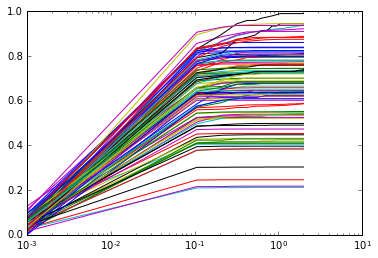

In [45]:
windowList = np.linspace(0.001,2,20)

for a in annotations:

    refPath = os.path.join(refBaseDir,a)
    estPath = os.path.join(estBaseDir,a)

    j_ref = jams.load(refPath)
    j_est = jams.load(estPath)

    onset_ref = getOnsetTimes(j_ref)
    onset_est = getOnsetTimes(j_est)




    F = [mir_eval.onset.evaluate(onset_ref, onset_est,window=w)['F-measure'] for w in windowList]
    
    plt.plot(windowList, F)
    plt.xscale('log')


In [ ]:
## this works, but is slow, switch order of loops to avoid I/O problems

keyList  = ['relStemPowerBin', 'onsetSource', 'polyphony']
summary = []

for key in keyList:
    
    D = pd.DataFrame()
    for a in annotations[0:2]:

        refPath = os.path.join(refBaseDir,a)
        estPath = os.path.join(estBaseDir,a)

        j_ref = jams.load(refPath)
        j_est = jams.load(estPath)

        onset_ref = getOnsetTimes(j_ref)
        onset_est = getOnsetTimes(j_est)

        match = mir_eval.util.match_events(onset_ref,onset_est,0.05)

        est_idxTruePos = [m[1] for m in match]
        est_idxFalsePos = findMissing(est_idxTruePos, onset_est)

        ref_idxTruePos = [m[0] for m in match]
        ref_idxFalseNeg = findMissing(ref_idxTruePos, onset_ref)

        df = pd.DataFrame(j_ref.search(namespace='onset')[0].data.value.tolist())
        df.onsetSource = df.onsetSource.map(lambda x: "/".join(x))
        df['relStemPower'] = df.powerStem - df.powerMix 
        df['relStemPower'] = df.powerStem - df.powerMix 
        df['relStemPowerBin'] = pd.cut(df.relStemPower,bins = np.linspace(-70,2,25))
        df['TP'] = 0
        df['FN'] = 0

        df['TP'].loc[ref_idxTruePos] = 1
        df['FN'].loc[ref_idxFalseNeg] = 1

        groupedDF = df[['TP','FN',key]].groupby(key).sum()

        D = D.add(groupedDF,fill_value=0)
    
    summary.append(D)